# Multi Color Light Curves from Lauren macArthur applied to November/december visits at AuxTel, Using Spectro Data

- creation date 2024-03-21
- last update 2024-03-21
  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399

 

In [1]:
from lsst.daf.butler import Butler

import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom
import pickle

In [2]:
saveDir = "./lc_output_auxtelfall2023_spectro"
doSaveFigs = False  # set to True if you actually want to save the figures in the above dir

In [3]:
# Set some selections for reliable data
minNumMatches = 3
minSnCalibFlux = 50  # 100

In [4]:
# INSERT YOUR auxTel/LATISS collection and tract/band HERE
butlerRoot = "/repo/embargo"
# collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20231207/w_2023_49/PREOPS-4648"
collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871"

collectionStr = collection.replace("/", "_")
instrument = "LATISS"
skymapName = "latiss_v1"
#band = "i"
#tract = 5615
band = "y"
tract = 3864

calibFluxStr = "apFlux_35_0_instFlux"

file_output_selectedsources = f"lightcurves-selectedsources_tract{tract}_band{band}_novdec2023.csv"
fullname_file_output_selectedsources = os.path.join(saveDir,file_output_selectedsources)

## Selected Visits and Selected Nights

In [5]:
file_selected_visits = "../data/202402/SelectedVisits_fall2023_tract_3864.csv"
file_selected_nights = "AuxtelSpectroData/AtmParamPerNightObsDict_fall2023.pkl"

In [6]:
df_myselectedvisits = pd.read_csv(file_selected_visits,index_col=0)
my_selectedvisits = list(df_myselectedvisits.index)

In [7]:
#move the visitid as a column not to loose it during the merge 
df_myselectedvisits.reset_index(inplace=True) 

In [8]:
df_myselectedvisits

,visitId,nightObs,physical_filter,band,zeroPoint,expMidptMJD,obsStart,obsStartMJD,Time,airmass,patchID,tractID
0,2023112100506,20231121,SDSSg_65mm~empty,g,28.037330,60270.293207,2023-11-22 07:01:58.064996,60270.293033,2023-11-22 07:01:58.064996,1.087878,3864,237
1,2023112100507,20231121,SDSSr_65mm~empty,r,27.826233,60270.293745,2023-11-22 07:02:44.576007,60270.293571,2023-11-22 07:02:44.576007,1.086620,3864,237
2,2023112100508,20231121,SDSSz_65mm~empty,z,27.281532,60270.294284,2023-11-22 07:03:31.156006,60270.294111,2023-11-22 07:03:31.156006,1.085371,3864,237
3,2023112100509,20231121,empty~SDSSy_65mm,y,26.175438,60270.294842,2023-11-22 07:04:19.313506,60270.294668,2023-11-22 07:04:19.313506,1.084094,3864,237
4,2023112100510,20231121,SDSSg_65mm~empty,g,28.049168,60270.295844,2023-11-22 07:05:45.944508,60270.295671,2023-11-22 07:05:45.944508,1.081935,3864,236
...,...,...,...,...,...,...,...,...,...,...,...,...
871,2023122200530,20231222,empty~SDSSy_65mm,y,26.290860,60301.274438,2023-12-23 06:34:56.432498,60301.274264,2023-12-23 06:34:56.432498,1.006569,3864,236
872,2023122200531,20231222,SDSSg_65mm~empty,g,28.088020,60301.275506,2023-12-23 06:36:28.743997,60301.275333,2023-12-23 06:36:28.743997,1.006333,3864,236
873,2023122200532,20231222,SDSSr_65mm~empty,r,27.858763,60301.276044,2023-12-23 06:37:15.228995,60301.275871,2023-12-23 06:37:15.228995,1.006219,3864,236
874,2023122200533,20231222,SDSSz_65mm~empty,z,27.357218,60301.276586,2023-12-23 06:38:02.021494,60301.276412,2023-12-23 06:38:02.021494,1.006114,3864,236


In [9]:
# Check the night selected
df_myselectedvisits['nightObs'].unique()

array([20231121, 20231127, 20231128, 20231129, 20231130, 20231204,
       20231205, 20231206, 20231211, 20231214, 20231215, 20231220,
       20231221, 20231222])

### Make the dataframe holding the atmospheric parameters

In [10]:
df_selnight = pd.DataFrame(columns=('nightObs', 'PWV', 'VAOD','Grey',"Ozone"))
with open(file_selected_nights, 'rb') as fp:
    selectedNightsDict  = pickle.load(fp)
idx=0
for key,value in selectedNightsDict.items():
    pwv = value['median']['median_param_atm']['md_PWV']
    vaod = value['median']['median_param_atm']['md_VAOD']
    grey = value['median']['median_param_atm']['md_grey']
    ozone = value['median']['median_param_atm']['md_ozone']
    df_selnight.loc[idx] = [int(key),pwv,vaod,grey,ozone]
    idx+=1

In [11]:
# Convert the nightObs as an integer
df_selnight = df_selnight.astype({'nightObs':'int'})

In [12]:
df_night_to_atm = df_selnight.copy().set_index('nightObs')

In [13]:
df_night_to_atm

,PWV,VAOD,Grey,Ozone
nightObs,,,,
20230927,1.360643,0.006606,0.962204,322.459010
20230928,2.172185,0.000000,0.957690,309.241099
20231010,2.323852,0.006589,0.963656,328.488524
20231107,2.101962,0.013239,0.972018,304.659232
20231113,2.547404,0.009443,0.962289,339.184216
20231114,2.880052,0.009948,0.966162,322.515609
20231115,2.577242,0.002186,0.948540,317.834236
20231116,2.297691,0.006841,0.949698,348.357957
20231120,2.599672,0.017588,0.984415,315.151618


In [14]:
df_night_to_atm.loc[20231127]

PWV        3.551770
VAOD       0.004201
Grey       0.967583
Ozone    305.884093
Name: 20231127, dtype: float64

In [15]:
df_selnight['nightObs'].unique()

array([20230927, 20230928, 20231010, 20231107, 20231113, 20231114,
       20231115, 20231116, 20231120, 20231127, 20231128, 20231129,
       20231130, 20231204, 20231205, 20231206, 20231207])

## Merge the two datasets

- My selected visit with the atmospheric parameter

- kepp the intersection

In [16]:
df_merge = df_myselectedvisits.merge(df_selnight, left_on='nightObs',right_on='nightObs',how="inner")

In [17]:
df_merge['nightObs'].unique()

array([20231127, 20231128, 20231129, 20231130, 20231204, 20231205,
       20231206])

In [18]:
df_myselectedvisits = df_merge.copy()

In [19]:
df_myselectedvisits

,visitId,nightObs,physical_filter,band,zeroPoint,expMidptMJD,obsStart,obsStartMJD,Time,airmass,patchID,tractID,PWV,VAOD,Grey,Ozone
0,2023112700289,20231127,SDSSg_65mm~empty,g,28.049986,60276.274623,2023-11-28 06:35:12.465999,60276.274450,2023-11-28 06:35:12.465999,1.093019,3864,237,3.551770,0.004201,0.967583,305.884093
1,2023112700290,20231127,SDSSr_65mm~empty,r,27.843603,60276.275165,2023-11-28 06:35:59.225506,60276.274991,2023-11-28 06:35:59.225506,1.091708,3864,237,3.551770,0.004201,0.967583,305.884093
2,2023112700291,20231127,SDSSz_65mm~empty,z,27.314777,60276.275706,2023-11-28 06:36:45.996996,60276.275532,2023-11-28 06:36:45.996996,1.090408,3864,237,3.551770,0.004201,0.967583,305.884093
3,2023112700292,20231127,empty~SDSSy_65mm,y,26.169914,60276.276261,2023-11-28 06:37:33.978497,60276.276088,2023-11-28 06:37:33.978497,1.089088,3864,237,3.551770,0.004201,0.967583,305.884093
4,2023112700293,20231127,SDSSg_65mm~empty,g,28.077412,60276.277268,2023-11-28 06:39:00.978991,60276.277095,2023-11-28 06:39:00.978991,1.086840,3864,237,3.551770,0.004201,0.967583,305.884093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,2023120600314,20231206,empty~SDSSy_65mm,y,26.273216,60285.309672,2023-12-07 07:25:40.656999,60285.309498,2023-12-07 07:25:40.656999,1.009665,3864,236,1.745412,0.007880,0.949152,313.621492
427,2023120600315,20231206,SDSSg_65mm~empty,g,28.086746,60285.310672,2023-12-07 07:27:07.101494,60285.310499,2023-12-07 07:27:07.101494,1.009217,3864,236,1.745412,0.007880,0.949152,313.621492
428,2023120600316,20231206,SDSSr_65mm~empty,r,27.864086,60285.311213,2023-12-07 07:27:53.827494,60285.311040,2023-12-07 07:27:53.827494,1.008973,3864,236,1.745412,0.007880,0.949152,313.621492
429,2023120600317,20231206,SDSSz_65mm~empty,z,27.352793,60285.311755,2023-12-07 07:28:40.619498,60285.311581,2023-12-07 07:28:40.619498,1.008738,3864,236,1.745412,0.007880,0.949152,313.621492


In [20]:
my_selectedvisits = list(df_myselectedvisits.visitId)

In [21]:
df_atm = df_myselectedvisits[["visitId","PWV","VAOD","Grey","Ozone"]]

## Config

In [22]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collection, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
skymap = butler.get("skyMap")
print("camera_name = {}".format(camera.getName()))
print("collection = {}".format(collection))

camera_name = LATISS
collection = LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871


In [23]:
# Try to get the Schema
data_product = "isolated_star_sources"
datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collection, where= "instrument='LATISS'")
for i, ref in enumerate(datasetRefs):
    print(i,ref)
    butler_data = butler.get(ref)
    break

if not isinstance(butler_data, pd.core.frame.DataFrame):
    print(butler_data.getSchema())

0 isolated_star_sources@{instrument: 'LATISS', skymap: 'latiss_v1', tract: 383} [sc=DataFrame] (run=LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871/20240206T160257Z id=784d3e58-a02e-4e74-9d48-76b15ff6921c)


## isolated_star_sources Keeping all bands here, but keep the tract selection

The main starting point is the table of isolated_star_sources which has been constructed in step 2a from a catalog
Note that isolated star sources are associated to an object (a static starobject)
Here the work is doneband by band.
It is a good idea to work band by band.

In [24]:
# Load in isolated_star_sources and trim to band of interest and select the tract
isolatedStarSourcesFull = butler.get("isolated_star_sources", tract=tract)
#isolatedStarSourcesFull = isolatedStarSourcesFull[isolatedStarSourcesFull["band"] == band]

In [25]:
isolatedStarSourcesFull.head()

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
0,713,178244558356742858,2023111500493,0,122.502819,-36.181372,empty~SDSSi_65mm,i,18175.596494,576.145944,3089.041514,3522.968126,18884.539910,812.086676,False,-0.046051,False,713,0
1,755,178244561577968372,2023111500496,0,122.502816,-36.181375,empty~SDSSi_65mm,i,17565.087785,575.726251,2534.640599,3530.208921,17731.305191,812.327495,False,0.076945,False,755,0
2,670,178244564799193759,2023111500499,0,122.502820,-36.181372,empty~SDSSi_65mm,i,18116.303929,589.631325,1981.029109,3539.453433,19207.199949,833.032409,False,0.060362,False,670,0
3,679,178244568020419240,2023111500502,0,122.502819,-36.181372,empty~SDSSi_65mm,i,17729.923577,576.995488,1425.821552,3545.346614,18735.842581,814.675518,False,0.163642,False,679,0
4,576,178244574462870081,2023111500508,0,122.502817,-36.181375,empty~SDSSi_65mm,i,19275.159892,574.297890,315.295535,3562.070830,21449.774805,811.090466,False,0.462267,False,576,0


In [26]:
isolatedStarSourcesFull.columns

Index(['index', 'sourceId', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_35_0_instFlux',
       'apFlux_35_0_instFluxErr', 'x', 'y', 'apFlux_50_0_instFlux',
       'apFlux_50_0_instFluxErr', 'apFlux_50_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'source_row',
       'obj_index'],
      dtype='object')

## Select the visits in the preselected list

I add here my filter to select the visits I want to focus on from file_selected_visits = "../data/202402/SelectedVisits_fall2023_tract_3864.csv"
It include all bands

In [27]:
def SelectByVisit(row):
    if row["visit"] in my_selectedvisits:
        return True
    else:
        return False

In [28]:
isolatedStarSourcesFull["flag"] = isolatedStarSourcesFull.apply(SelectByVisit,axis=1,raw=False)

In [29]:
isolatedStarSourcesFull = isolatedStarSourcesFull[isolatedStarSourcesFull["flag"]]
isolatedStarSourcesFull.drop("flag",axis=1,inplace=True)

In [30]:
isolatedStarSourcesFull

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
65,457,178666553925960138,2023112700291,0,122.502820,-36.181375,SDSSz_65mm~empty,z,12747.998105,581.753474,3382.237020,2386.535105,13625.474026,823.982022,False,0.343975,False,457,0
66,439,178666558220927416,2023112700295,0,122.502811,-36.181367,SDSSz_65mm~empty,z,11429.435693,584.693261,2822.350901,2395.927091,10438.395404,828.670834,False,-0.285304,False,439,0
67,444,178666562515894717,2023112700299,0,122.502809,-36.181370,SDSSz_65mm~empty,z,13437.688221,598.552525,2260.433610,2402.958995,14843.517451,848.842429,False,0.230724,False,444,0
68,465,178666566810862034,2023112700303,0,122.502814,-36.181377,SDSSz_65mm~empty,z,12200.829655,608.758263,1697.099221,2408.426848,12728.064110,862.975811,False,0.265856,False,465,0
69,419,178666571105829284,2023112700307,0,122.502818,-36.181374,SDSSz_65mm~empty,z,10161.510211,595.458916,1135.841754,2416.271198,9151.938139,844.237599,False,-0.167469,False,419,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152510,353,178666567884603746,2023112700304,0,122.576029,-36.164206,empty~SDSSy_65mm,y,7185.374436,533.317917,3920.129974,3026.403433,6955.290241,757.876120,False,0.034168,False,353,1339
152511,352,178702004586021217,2023112800539,0,122.576085,-36.164206,empty~SDSSy_65mm,y,7148.755773,574.771613,2837.448268,3693.434127,6602.269557,816.525462,False,-0.110343,False,352,1339
152512,406,178737183589400983,2023112900534,0,122.576099,-36.164219,empty~SDSSy_65mm,y,7905.773580,536.178851,3606.528284,3613.604361,7810.166903,762.255784,False,-0.154883,False,406,1339
152513,115,178772378698907764,2023113000544,0,122.581152,-36.233899,empty~SDSSy_65mm,y,416775.825060,825.279582,3894.570463,1092.870408,437487.553789,1011.282391,False,1.237371,False,115,1340


## Add atmospheric quantities to the isolatedStarSourcesFull

In [31]:
isolatedStarSourcesFull = isolatedStarSourcesFull.merge(df_atm, left_on='visit',right_on='visitId',how="inner")
isolatedStarSourcesFull["nightObs"] = isolatedStarSourcesFull.apply(lambda x: x['visit']//100_000, axis=1)
isolatedStarSourcesFull

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,visitId,PWV,VAOD,Grey,Ozone,nightObs
0,457,178666553925960138,2023112700291,0,122.502820,-36.181375,SDSSz_65mm~empty,z,12747.998105,581.753474,3382.237020,2386.535105,13625.474026,823.982022,False,0.343975,False,457,0,2023112700291,3.551770,0.004201,0.967583,305.884093,20231127
1,514,178666553925960195,2023112700291,0,122.497986,-36.173216,SDSSz_65mm~empty,z,14464.894159,585.974220,3239.489619,2695.313259,14665.370806,828.493855,False,-0.056541,False,514,2,2023112700291,3.551770,0.004201,0.967583,305.884093,20231127
2,505,178666553925960186,2023112700291,0,122.486996,-36.174438,SDSSz_65mm~empty,z,46465.109238,612.160990,2905.201660,2653.676707,45553.918232,848.659952,False,-0.200783,False,505,3,2023112700291,3.551770,0.004201,0.967583,305.884093,20231127
3,411,178666553925960092,2023112700291,0,122.520431,-36.187896,SDSSz_65mm~empty,z,15814.180282,554.156331,3913.659231,2134.246089,16044.713554,782.601740,False,0.126033,False,411,5,2023112700291,3.551770,0.004201,0.967583,305.884093,20231127
4,460,178666553925960141,2023112700291,0,122.513234,-36.180948,SDSSz_65mm~empty,z,34217.183036,565.581218,3698.656528,2398.479751,35049.844366,788.184754,False,0.232790,False,460,6,2023112700291,3.551770,0.004201,0.967583,305.884093,20231127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43415,156,178737288816099485,2023112900632,0,122.438489,-36.222594,empty~SDSSy_65mm,y,65860.221341,679.413319,2294.932623,1400.083499,67947.566082,938.270730,False,0.238771,False,156,1041,2023112900632,3.137323,0.007454,0.965610,294.848216,20231129
43416,360,178737288816099689,2023112900632,0,122.436026,-36.172113,empty~SDSSy_65mm,y,7718.800287,573.490174,2245.197983,3299.364090,8059.304354,815.039076,False,0.010445,False,360,1044,2023112900632,3.137323,0.007454,0.965610,294.848216,20231129
43417,256,178737288816099585,2023112900632,0,122.424413,-36.197923,empty~SDSSy_65mm,y,161716.452929,705.333578,1879.864027,2333.332603,171169.378938,930.194281,False,1.364252,False,256,1071,2023112900632,3.137323,0.007454,0.965610,294.848216,20231129
43418,145,178737288816099474,2023112900632,0,122.381425,-36.226526,empty~SDSSy_65mm,y,7578.970429,663.062178,561.317379,1274.236020,7412.962573,943.857395,False,-0.059202,False,145,1092,2023112900632,3.137323,0.007454,0.965610,294.848216,20231129


In [32]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,visitId,PWV,VAOD,Grey,Ozone,nightObs
0,457,178666553925960138,2023112700291,0,122.50282,-36.181375,SDSSz_65mm~empty,z,12747.998105,581.753474,3382.23702,2386.535105,13625.474026,823.982022,False,0.343975,False,457,0,2023112700291,3.55177,0.004201,0.967583,305.884093,20231127


In [33]:
print("calibFluxStr = {},,minSnCalibFlux = {}, minNumMatches = {}".format(calibFluxStr,minSnCalibFlux,minNumMatches))

calibFluxStr = apFlux_35_0_instFlux,,minSnCalibFlux = 50, minNumMatches = 3


## Select a number of visits with enough good sources but in all bands here

- extract the list of known objects

In [34]:
# Trim the isolated_star_sources cat to those PSF S/N > minSnCalibFlux
# and number of matches sources > minNumMatches.
objIndexListFull = list(set(isolatedStarSourcesFull["obj_index"].values))

# Select the bright stars above a minimum of S/N ratio
if minSnCalibFlux is not None:
    snCalibFlux = isolatedStarSourcesFull[calibFluxStr]/isolatedStarSourcesFull[calibFluxStr + "Err"]
    snMask = snCalibFlux > minSnCalibFlux
    isolatedStarSourcesMinSn = isolatedStarSourcesFull[snMask].copy(deep=True)
else:
    isolatedStarSourcesMinSn = isolatedStarSourcesFull.copy(deep=True)

# object index with obj index in above selected bright selected star
objIndexListMinSn = list(set(isolatedStarSourcesMinSn["obj_index"].values))

# requires that the object is associated to several sources (at least minNumMatches sources)
objIndexList = []
for objIndex in objIndexListMinSn:
    objData = isolatedStarSourcesMinSn[isolatedStarSourcesMinSn["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
numTrimmed = len(objIndexListFull) - len(objIndexList)

mask = []
for objIndex, visit in zip(isolatedStarSourcesMinSn["obj_index"], isolatedStarSourcesMinSn["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSourcesMinSn[mask].copy(deep=True)

# Select a number of visits according quality criteria
visitList = list(set(isolatedStarSources["visit"].values))

if minSnCalibFlux is not None:
    print("Trimmed isolated_star_sources catalog to S/N {} > {} (leaving N={} matched souces from original {})".format(
        calibFluxStr, minSnCalibFlux, len(isolatedStarSources), len(isolatedStarSourcesFull)))
print("Trimmed isolated_star_sources catalog to objecst with nMatches >= {} (leaving {} objects from {}).".format(
    minNumMatches, len(objIndexList), len(objIndexListFull)))

Trimmed isolated_star_sources catalog to S/N apFlux_35_0_instFlux > 50 (leaving N=11558 matched souces from original 43420)
Trimmed isolated_star_sources catalog to objecst with nMatches >= 3 (leaving 236 objects from 910).


In [35]:
sorted_visitList = sorted(visitList)
sorted_visitList[:20] 

[2023112700289,
 2023112700290,
 2023112700291,
 2023112700292,
 2023112700293,
 2023112700294,
 2023112700295,
 2023112700296,
 2023112700297,
 2023112700298,
 2023112700299,
 2023112700300,
 2023112700301,
 2023112700302,
 2023112700303,
 2023112700304,
 2023112700305,
 2023112700306,
 2023112700307,
 2023112700308]

In [36]:
def convertVisitToDatestr(visit):

    num = visit//100_000
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return datestr

In [37]:
def convertVisitToMJD(visit):
    return Time(convertVisitToDatestr(visit)).mjd

In [38]:
sorted_visits_mjd = list(map(convertVisitToMJD, sorted_visitList))

## sourceTable_visit

This is the main output of FGCM calibration which has selected a number of sources. These sources were originally selected from isolated sources.

In [39]:
# Extra columns to load from sourceTable_visit catalogs
names = ["psfFlux", "psfFluxErr", "psfFlux_flag", "psfFlux_apCorr", "psfFlux_apCorrErr",
         "extendedness", "detect_isPrimary", "deblend_skipped",
         "gaussianFlux", "gaussianFluxErr", "gaussianFlux_flag",
         "localPhotoCalib", "localPhotoCalibErr", "localPhotoCalib_flag"]

In [40]:
# Load in the sourceTable_visit catalogs to get the psfFlux and other useful info per source.
# Columns loaded are those in names above.
sourceCatalogs = []
nSourceDict = {}
visitsToRemove = []

# loop over all selected visit
for visit in visitList:
    try:
        sourceCatalogOrig = butler.get("sourceTable_visit", visit=visit, parameters={"columns": names})
        primaryCat = sourceCatalogOrig[sourceCatalogOrig["detect_isPrimary"]].copy(deep=True)
        nSourceDict[visit] = sum(primaryCat["psfFlux"]/primaryCat["psfFluxErr"] > 5)
        sourceCatalogs.append(primaryCat)
    except LookupError:
        print("sourceTable_visit not found for visit {}".format(visit))
        isolatedStarSources = isolatedStarSources[isolatedStarSources["visit"] != visit].copy(deep=True)
        visitsToRemove.append(visit)
visitList = list(set(visitList) - set(visitsToRemove))

# Do the minNumMatches cut again since visits may have been removed due to lack of sourceTable_visit
print("Number of objects with >=3 matches before sourceTable_visit exsistence check: {}".format(len(objIndexList)))
objIndexListAllNew = list(set(isolatedStarSources["obj_index"].values))
objIndexList = []
for objIndex in objIndexListAllNew:
    objData = isolatedStarSources[isolatedStarSources["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
mask = []
for objIndex, visit in zip(isolatedStarSources["obj_index"], isolatedStarSources["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSources[mask].copy(deep=True)
visitList = list(set(isolatedStarSources["visit"].values))
print("Number of objects with >=3 matches after sourceTable_visit exsistence check: {}".format(len(objIndexList)))
dataJoined = pd.concat(sourceCatalogs).merge(isolatedStarSources, on="sourceId", how="inner")

Number of objects with >=3 matches before sourceTable_visit exsistence check: 236
Number of objects with >=3 matches after sourceTable_visit exsistence check: 236


In [41]:
visitsToRemove 

[]

## Will start to work on dataJoined which associate selected "isolated_star_sources" in the selected band and visits the good calibration in "sourceTable_visit"

### add my info from CCD Visit Table

- CCD visit table is a pre-FGCM calibration
- it provides airmass and initial zero-point

In [42]:
# need also. ["zeroPoint","airmass"]

In [43]:
# Collect useful columns from ccdVisitTable
ccdVisitTable = butler.get("ccdVisitTable")
ccdVisitTable["airmass"] = ccdVisitTable["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))
ccdVisitTable["medianE"] = np.sqrt(ccdVisitTable["psfStarDeltaE1Median"] ** 2.0 + 
                                    ccdVisitTable["psfStarDeltaE2Median"] ** 2.0)
psfSigmaDict = {}
skyBgDict = {}
skyNoiseDict = {}
expTimeDict = {}
expMidptMjdDict = {}
medianEDict = {}
psfStarScaledDeltaSizeScatterDict = {}
astromOffsetStdDict = {}
psfTraceRadiusDeltaDict = {}
zeroPointDict = {}
airmassDict = {}
# for visit in ccdVisitTable["visitId"].values:
#     if visit in visitList:
for visit in visitList:
    if visit in ccdVisitTable["visitId"].values:
        psfSigmaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfSigma"].values[0]
        skyBgDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyBg"].values[0]
        skyNoiseDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyNoise"].values[0]
        expTimeDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expTime"].values[0]
        expMidptMjdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expMidptMJD"].values[0]
        medianEDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["medianE"].values[0]
        psfStarScaledDeltaSizeScatterDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfStarScaledDeltaSizeScatter"].values[0]
        astromOffsetStdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["astromOffsetStd"].values[0]
        psfTraceRadiusDeltaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfTraceRadiusDelta"].values[0]
        zeroPointDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["zeroPoint"].values[0]
        airmassDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["airmass"].values[0]
    else:
        raise RuntimeError("ERROR: visit {} not found in ccdVisitTable".format(visit))

In [44]:
# Just to have a look at what's in the catalog:
ccdVisitTable[ccdVisitTable.index == ccdVisitTable.index[0]] 

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946728,-24.053747,56.749516,27.690649,7.814408,11.197219,7.856582,0.026538,0.014041,42,-0.007038,0.000486,0.032627,0.014318,0.107089,0.110564,0.013839,0.879543,2160.236328,0.207786,0.016376,2.679237,0.157862,-24.053747,0,1.761132,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.0477,30.2434,4071,3999,239.935567,-24.128924,240.029265,-24.062574,239.957876,-23.978569,239.864202,-24.044875,1.823818,0.007055


In [45]:
dataJoined.columns

Index(['sourceId', 'psfFlux', 'psfFluxErr', 'psfFlux_flag', 'psfFlux_apCorr',
       'psfFlux_apCorrErr', 'extendedness', 'detect_isPrimary',
       'deblend_skipped', 'gaussianFlux', 'gaussianFluxErr',
       'gaussianFlux_flag', 'localPhotoCalib', 'localPhotoCalibErr',
       'localPhotoCalib_flag', 'index', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_35_0_instFlux',
       'apFlux_35_0_instFluxErr', 'x', 'y', 'apFlux_50_0_instFlux',
       'apFlux_50_0_instFluxErr', 'apFlux_50_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'source_row',
       'obj_index', 'visitId', 'PWV', 'VAOD', 'Grey', 'Ozone', 'nightObs'],
      dtype='object')

In [46]:
# Add columns into dataJoined table to have them all in one place
dataJoined["psfSn"] = dataJoined["psfFlux"]/dataJoined["psfFluxErr"]
dataJoined["psfMag"] = (dataJoined["psfFlux"].values*u.nJy).to(u.ABmag).value
dataJoined["psfMagErr"] = 2.5/np.log(10.0)*(dataJoined["psfFluxErr"].values/dataJoined["psfFlux"].values)

#dataJoined["apFlux_35_0_calFlux"] = dataJoined["apFlux_35_0_instFlux"]*dataJoined["localPhotoCalib"]
#dataJoined["apFlux_35_0_calFluxErr"] = dataJoined["apFlux_35_0_instFluxErr"]*dataJoined["localPhotoCalib"]
# This is the way to apply aperture corrections :
dataJoined["apFlux_35_0_calFlux"] = dataJoined["apFlux_35_0_instFlux"]*dataJoined["localPhotoCalib"]*dataJoined['psfFlux_apCorr']
dataJoined["apFlux_35_0_calFluxErr"] = dataJoined["apFlux_35_0_instFluxErr"]*dataJoined["localPhotoCalib"]*dataJoined['psfFlux_apCorr']

# NOTE: psfFlux is the fgcm calibrated flux.  I'm pretty sure you get the "instrumental" 
# flux by dividing psfFlux by the localPhotoCalib value.
dataJoined["psfInstMag"] = ((dataJoined["psfFlux"].values/dataJoined["localPhotoCalib"].values)*u.nJy).to(u.ABmag).value
dataJoined["psfGausFluxRatio"] = dataJoined["psfFlux"]/dataJoined["gaussianFlux"]
dataJoined["psfSigma"] = dataJoined.apply(lambda x: psfSigmaDict[x["visit"]], axis=1)
dataJoined["skyBg"] = dataJoined.apply(lambda x: skyBgDict[x["visit"]], axis=1)
dataJoined["expTime"] = dataJoined.apply(lambda x: expTimeDict[x["visit"]], axis=1)
dataJoined["expMidptMjd"] = dataJoined.apply(lambda x: expMidptMjdDict[x["visit"]], axis=1)
dataJoined["nSource"] = dataJoined.apply(lambda x: nSourceDict[x["visit"]], axis=1)
dataJoined["medianE"] = dataJoined.apply(lambda x: medianEDict[x["visit"]], axis=1)
dataJoined["psfStarScaledDeltaSizeScatter"] = dataJoined.apply(lambda x: psfStarScaledDeltaSizeScatterDict[x["visit"]], axis=1)
dataJoined["astromOffsetStd"] = dataJoined.apply(lambda x: astromOffsetStdDict[x["visit"]], axis=1)
dataJoined["psfTraceRadiusDelta"] = dataJoined.apply(lambda x: psfTraceRadiusDeltaDict[x["visit"]], axis=1)

# I add the airmass and zero-point I want to keep here
dataJoined["zeroPoint"] = dataJoined.apply(lambda x: zeroPointDict[x["visit"]], axis=1)
dataJoined["airmass"] = dataJoined.apply(lambda x: airmassDict[x["visit"]], axis=1)

matchedObjIdList = list(set(dataJoined["obj_index"]))

In [47]:
dataJoined[dataJoined.index == 0]

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,visitId,PWV,VAOD,Grey,Ozone,nightObs,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,psfInstMag,psfGausFluxRatio,psfSigma,skyBg,expTime,expMidptMjd,nSource,medianE,psfStarScaledDeltaSizeScatter,astromOffsetStd,psfTraceRadiusDelta,zeroPoint,airmass
0,178737285594873891,5.797313e+06,21657.034012,False,1.014556,0.0,0.0,True,False,5.760178e+06,24942.972342,False,29.117638,0.06469,False,34,2023112900629,0,122.42874,-36.252168,SDSSg_65mm~empty,g,202203.32798,777.272089,1988.651063,293.732243,207069.167938,1018.875651,False,0.335017,False,34,672,2023112900629,3.137323,0.007454,0.96561,294.848216,20231129,267.68732,14.491933,0.004056,5.973385e+06,22961.766414,18.152323,1.006447,5.925731,16.766493,30.0,60278.33176,419,0.007846,0.011148,0.006907,0.461398,27.703104,1.008283


## The association between the independent sources is done through the object index 

- for plotting the repeatability

In [48]:
# Compute repeatability related values per object/object group and add
# them inplace to the dataJoined DataFrame.
psfMagDiffMmagDfList = []
psfMagStdMmagAll = []
psfMagStdMmagDict = {}
psfMagDiffChiDfList = []
psfSnAll = []
raDiffMasDfList = []
decDiffMasDfList = []
raCosDecDiffMasDfList = []
objRaDegList = []
objDecDegList = []
raStdMasAll = []
decStdMasAll = []
raCosDecStdMasAll = []
objDataList = []

# loop on objects
for objIndex in matchedObjIdList:
    # select sources corresponding to that object
    objData = dataJoined[dataJoined["obj_index"] == objIndex]
    psfMag = objData["psfMag"]
    psfMagErr = objData["psfMagErr"]

    # average flux over all visits
    clippedMeanMagArray = scipy.stats.sigmaclip(psfMag, low=3.0, high=3.0).clipped
    clippedMeanMag = np.mean(clippedMeanMagArray)
    clippedMeanMagErr = np.std(clippedMeanMagArray)/np.sqrt(len(clippedMeanMagArray))

    # array of difference between flux an clipped mean average
    psfMagDiffMmag = 1000*(psfMag - clippedMeanMag)
    # sigma arrays over the difference
    psfMagStdMmag = np.std(psfMagDiffMmag)
    # residuals array
    psfMagDiffChi = (psfMag - clippedMeanMag)/np.sqrt(psfMagErr**2 + clippedMeanMagErr**2)
    
    clippedMeanRaArray = scipy.stats.sigmaclip(objData["ra"], low=3.0, high=3.0).clipped
    clippedMeanRa = np.mean(clippedMeanRaArray)
    raDiffMas = (objData["ra"] - clippedMeanRa)*3600*1000
    
    clippedMeanDecArray = scipy.stats.sigmaclip(objData["dec"], low=3.0, high=3.0).clipped
    clippedMeanDec = np.mean(clippedMeanDecArray)
    decDiffMas = (objData["dec"] - clippedMeanDec)*3600*1000
    
    raCosDec = np.deg2rad(objData["ra"])*np.cos(np.deg2rad(objData["dec"]))
    clippedMeanRaCosDecArray = scipy.stats.sigmaclip(raCosDec, low=3.0, high=3.0).clipped
    clippedMeanRaCosDec = np.mean(clippedMeanRaCosDecArray)
    raCosDecDiffRad = (raCosDec - clippedMeanRaCosDec)
    raCosDecDiffMas = np.rad2deg(raCosDecDiffRad)*3600*1000

    # save for all sources of the object
    psfMagDiffMmagDfList.append(psfMagDiffMmag)
    psfMagStdMmagAll.append(psfMagStdMmag)
    psfMagDiffChiDfList.append(psfMagDiffChi)

    raDiffMasDfList.append(raDiffMas)
    decDiffMasDfList.append(decDiffMas)
    raCosDecDiffMasDfList.append(raCosDecDiffMas)
    
    objRaDegList.append(clippedMeanRa)
    objDecDegList.append(clippedMeanDec)

    raStdMas = np.std(raDiffMas)
    raStdMasAll.append(raStdMas)
    decStdMas = np.std(decDiffMas)
    decStdMasAll.append(decStdMas)
    raCosDecStdMas = np.std(raCosDecDiffMas)
    raCosDecStdMasAll.append(raCosDecStdMas)
    psfMagStdMmagDict[objIndex] = psfMagStdMmag

# concatenate over all objects - all sources
psfMagDiffMmagDf = pd.concat(psfMagDiffMmagDfList)
psfMagDiffChiDf = pd.concat(psfMagDiffChiDfList)
raDiffMasDf = pd.concat(raDiffMasDfList)
decDiffMasDf = pd.concat(decDiffMasDfList)
raCosDecDiffMasDf = pd.concat(raCosDecDiffMasDfList)

# add this common properties to each source in dataJoined
dataJoined.loc[:, "psfMagDiffMmag"] = psfMagDiffMmagDf
dataJoined.loc[:, "psfMagDiffChi"] = psfMagDiffChiDf
dataJoined.loc[:, "raDiffMas"] = raDiffMasDf
dataJoined.loc[:, "decDiffMas"] = decDiffMasDf
dataJoined.loc[:, "raCosDecDiffMas"] = raCosDecDiffMasDf

In [49]:
dataJoined[dataJoined.index == 0]

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,visitId,PWV,VAOD,Grey,Ozone,nightObs,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,psfInstMag,psfGausFluxRatio,psfSigma,skyBg,expTime,expMidptMjd,nSource,medianE,psfStarScaledDeltaSizeScatter,astromOffsetStd,psfTraceRadiusDelta,zeroPoint,airmass,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas
0,178737285594873891,5.797313e+06,21657.034012,False,1.014556,0.0,0.0,True,False,5.760178e+06,24942.972342,False,29.117638,0.06469,False,34,2023112900629,0,122.42874,-36.252168,SDSSg_65mm~empty,g,202203.32798,777.272089,1988.651063,293.732243,207069.167938,1018.875651,False,0.335017,False,34,672,2023112900629,3.137323,0.007454,0.96561,294.848216,20231129,267.68732,14.491933,0.004056,5.973385e+06,22961.766414,18.152323,1.006447,5.925731,16.766493,30.0,60278.33176,419,0.007846,0.011148,0.006907,0.461398,27.703104,1.008283,478.310914,12.935085,14.812157,8.150911,22.244071


In [50]:
dataJoined.head()

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,visitId,PWV,VAOD,Grey,Ozone,nightObs,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,psfInstMag,psfGausFluxRatio,psfSigma,skyBg,expTime,expMidptMjd,nSource,medianE,psfStarScaledDeltaSizeScatter,astromOffsetStd,psfTraceRadiusDelta,zeroPoint,airmass,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas
0,178737285594873891,5.797313e+06,21657.034012,False,1.014556,0.0,0.0,True,False,5.760178e+06,24942.972342,False,29.117638,0.06469,False,34,2023112900629,0,122.428740,-36.252168,SDSSg_65mm~empty,g,202203.327980,777.272089,1988.651063,293.732243,207069.167938,1018.875651,False,0.335017,False,34,672,2023112900629,3.137323,0.007454,0.96561,294.848216,20231129,267.687320,14.491933,0.004056,5.973385e+06,22961.766414,18.152323,1.006447,5.925731,16.766493,30.0,60278.33176,419,0.007846,0.011148,0.006907,0.461398,27.703104,1.008283,478.310914,12.935085,14.812157,8.150911,22.244071
1,178737285594873907,2.413277e+06,13851.204003,False,1.011126,0.0,0.0,True,False,2.399630e+06,15895.754788,False,29.395255,0.06469,False,50,2023112900629,0,122.441629,-36.246919,SDSSg_65mm~empty,g,81936.174293,729.174794,2382.280722,486.067450,83719.762731,1003.564395,False,0.146979,False,50,579,2023112900629,3.137323,0.007454,0.96561,294.848216,20231129,174.228664,15.443482,0.006232,2.435332e+06,21672.755984,19.114175,1.005687,5.925731,16.766493,30.0,60278.33176,419,0.007846,0.011148,0.006907,0.461398,27.703104,1.008283,431.785190,12.388664,7.751699,0.490938,6.871883
2,178737285594873913,2.004479e+06,12636.459588,False,1.027130,0.0,0.0,True,False,2.008215e+06,14388.670886,False,28.784197,0.06469,False,56,2023112900629,0,122.377337,-36.246303,SDSSg_65mm~empty,g,69975.769089,694.129362,431.987236,533.876570,70285.446251,955.424969,False,-0.198553,False,56,1031,2023112900629,3.137323,0.007454,0.96561,294.848216,20231129,158.626610,15.644996,0.006845,2.068842e+06,20522.014827,19.292882,0.998139,5.925731,16.766493,30.0,60278.33176,419,0.007846,0.011148,0.006907,0.461398,27.703104,1.008283,578.218438,6.733594,-2.415302,-11.526410,-16.504138
3,178737285594873926,9.770555e+05,10015.817685,False,1.026424,0.0,0.0,True,False,9.986762e+05,11562.462235,False,28.803851,0.06469,False,69,2023112900629,0,122.374049,-36.241555,SDSSg_65mm~empty,g,34626.233615,669.218998,334.489152,713.650510,34386.383354,936.765022,False,-0.241294,False,69,1188,2023112900629,3.137323,0.007454,0.96561,294.848216,20231129,97.551251,16.425202,0.011130,1.023724e+06,19785.441904,20.073828,0.978351,5.925731,16.766493,30.0,60278.33176,419,0.007846,0.011148,0.006907,0.461398,27.703104,1.008283,464.021362,2.922155,9.752536,5.210533,14.444981
4,178737285594873990,1.245089e+06,10767.211066,False,1.020650,0.0,0.0,True,False,1.217147e+06,11996.455384,False,29.085783,0.06469,False,133,2023112900629,0,122.378173,-36.223377,SDSSg_65mm~empty,g,42698.487121,673.847367,468.237587,1395.686839,43807.462942,944.512627,False,-0.071078,False,133,769,2023112900629,3.137323,0.007454,0.96561,294.848216,20231129,115.637137,16.161999,0.009389,1.267565e+06,20004.109097,19.821200,1.022958,5.925731,16.766493,30.0,60278.33176,419,0.007846,0.011148,0.006907,0.461398,27.703104,1.008283,798.041339,6.877166,-3.236104,-0.751151,-7.603032


## Check the correlation between the flux psf and apperture flux

- The goal is to understand what flux is calibrated what flux is not calibrated 

In [51]:
dataJoined_subset = dataJoined[["obj_index","sourceId","band","visitId","ra","dec","psfMag","psfFlux","gaussianFlux","apFlux_35_0_calFlux", "apFlux_35_0_instFlux","psfFlux_apCorr",
                                "psfMagErr","psfFluxErr","gaussianFluxErr","apFlux_35_0_calFluxErr", "apFlux_35_0_instFluxErr","skyBg"]]

In [52]:
dataJoined_subset.sort_values(by=["obj_index","band","visitId"])

,obj_index,sourceId,band,visitId,ra,dec,psfMag,psfFlux,gaussianFlux,apFlux_35_0_calFlux,apFlux_35_0_instFlux,psfFlux_apCorr,psfMagErr,psfFluxErr,gaussianFluxErr,apFlux_35_0_calFluxErr,apFlux_35_0_instFluxErr,skyBg
225,3,178913086122492462,r,2023120400516,122.487004,-36.174436,16.776023,7.072793e+05,7.048022e+05,7.555057e+05,28729.467269,1.007692,0.010475,6823.894801,8034.079153,14512.774019,551.874407,6.196430
3749,3,178666553925960186,z,2023112700291,122.486996,-36.174438,15.622105,2.047189e+06,2.060119e+06,2.034171e+06,46465.109238,1.012310,0.007613,14353.931945,17927.497603,26799.466553,612.160990,19.386070
3853,3,178666558220927463,z,2023112700295,122.486998,-36.174441,15.623807,2.043983e+06,2.022984e+06,2.042983e+06,47865.536658,1.008453,0.007580,14270.788215,16174.249855,26660.394902,624.632634,18.905258
3969,3,178666562515894769,z,2023112700299,122.486999,-36.174440,15.623556,2.044455e+06,2.024384e+06,2.036848e+06,47326.503774,1.013965,0.007655,14414.105520,16370.561862,27486.489451,638.653092,19.160440
4086,3,178666566810862088,z,2023112700303,122.486998,-36.174437,15.656373,1.983584e+06,2.000095e+06,1.940386e+06,46564.162456,1.004123,0.007546,13786.790034,16051.030510,26007.027473,624.100423,18.282925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5515,1319,178983154218958972,g,2023120600236,122.532270,-36.233776,14.281605,7.036520e+06,6.824106e+06,7.034898e+06,307970.434137,1.036236,0.003022,19584.443007,21856.274743,17536.386449,767.699576,3.304182
5620,1319,178983158513926247,g,2023120600240,122.532263,-36.233775,14.369982,6.486450e+06,6.486922e+06,6.541757e+06,298862.040035,1.022669,0.003035,18133.101619,21261.193613,17987.351205,821.757344,3.375790
5747,1319,178983162808893590,g,2023120600244,122.532265,-36.233777,14.357361,6.562295e+06,6.497278e+06,6.616410e+06,304992.296618,1.007659,0.002797,16902.398421,19603.429490,18158.305605,837.031430,3.474576
5998,1319,178983171398828158,g,2023120600252,122.532263,-36.233775,14.350914,6.601375e+06,6.621183e+06,6.582967e+06,307665.086770,1.004259,0.002900,17631.029218,20806.419863,17267.697953,807.032362,3.773445


In [53]:
dataJoined_subset_g = dataJoined_subset[dataJoined_subset["band"] == "g"]
dataJoined_subset_r = dataJoined_subset[dataJoined_subset["band"] == "r"]
dataJoined_subset_z = dataJoined_subset[dataJoined_subset["band"] == "z"]
dataJoined_subset_y = dataJoined_subset[dataJoined_subset["band"] == "y"]

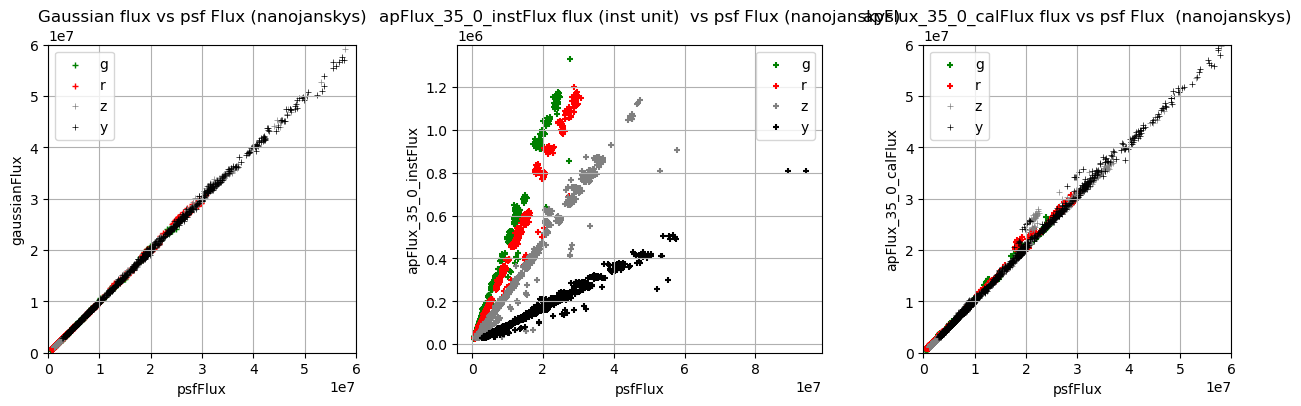

In [54]:
fig,axs = plt.subplots(1,3,figsize=(16,4))
ax=axs[0]
dataJoined_subset_g.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_z.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("equal")
ax.set_xlim(0.,0.6e8)
ax.set_ylim(0.,0.6e8)
ax.set_title("Gaussian flux vs psf Flux (nanojanskys)")
ax.grid()

ax=axs[1]
dataJoined_subset_g.plot.scatter(x="psfFlux",y="apFlux_35_0_instFlux",ax=ax,color="g",marker="+",label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y="apFlux_35_0_instFlux",ax=ax,color="r",marker="+",label="r")
dataJoined_subset_z.plot.scatter(x="psfFlux",y="apFlux_35_0_instFlux",ax=ax,color="grey",marker="+",label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y="apFlux_35_0_instFlux",ax=ax,color="k",marker="+",label="y")
ax.set_aspect("auto")
ax.set_title("apFlux_35_0_instFlux flux (inst unit)  vs psf Flux (nanojanskys)")
ax.grid()

ax=axs[2]
dataJoined_subset_g.plot.scatter(x="psfFlux",y="apFlux_35_0_calFlux",ax=ax,color="g",marker="+",label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y="apFlux_35_0_calFlux",ax=ax,color="r",marker="+",label="r")
dataJoined_subset_z.plot.scatter(x="psfFlux",y="apFlux_35_0_calFlux",ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y="apFlux_35_0_calFlux",ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("equal")
ax.set_xlim(0.,0.6e8)
ax.set_ylim(0.,0.6e8)
ax.set_title("apFlux_35_0_calFlux flux vs psf Flux  (nanojanskys)")
ax.grid()


Text(0.5, 0.98, 'All selected sources')

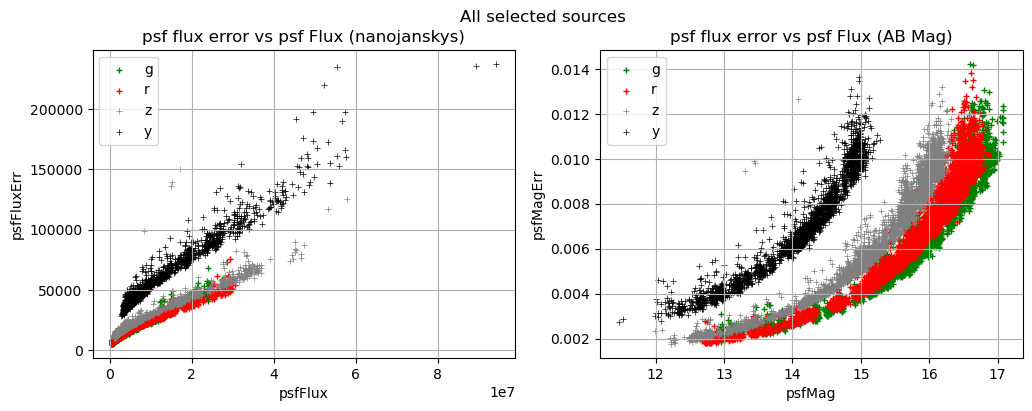

In [55]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
ax=axs[0]
dataJoined_subset_g.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_z.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("auto")

ax.set_title("psf flux error vs psf Flux (nanojanskys)")
ax.grid()

ax=axs[1]
dataJoined_subset_g.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_z.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("auto")

ax.set_title("psf flux error vs psf Flux (AB Mag)")
ax.grid()

plt.suptitle("All selected sources")

## Statistics on Light Curves

- want number of source per object

In [56]:
#my_list = list(dataJoined.columns)
#for name in my_list:
#    print(name)

#### Compute pandas series with multi-label or series per color 

In [57]:
count_source_visit = dataJoined_subset.groupby(by=["obj_index","band"]).count()["visitId"]
size_source_visit = dataJoined_subset.groupby(by=["obj_index","band"]).size()
count_source_visit_g = dataJoined_subset_g.groupby(by=["obj_index"]).count()["sourceId"]
count_source_visit_r = dataJoined_subset_r.groupby(by=["obj_index"]).count()["sourceId"]
count_source_visit_z = dataJoined_subset_z.groupby(by=["obj_index"]).count()["sourceId"]
count_source_visit_y = dataJoined_subset_y.groupby(by=["obj_index"]).count()["sourceId"]
size_source_visit_g = dataJoined_subset_g.groupby(by=["obj_index"]).size()
size_source_visit_r = dataJoined_subset_r.groupby(by=["obj_index"]).size()
size_source_visit_z = dataJoined_subset_z.groupby(by=["obj_index"]).size()
size_source_visit_y = dataJoined_subset_y.groupby(by=["obj_index"]).size()

Text(0.5, 0.98, 'number of sources per object')

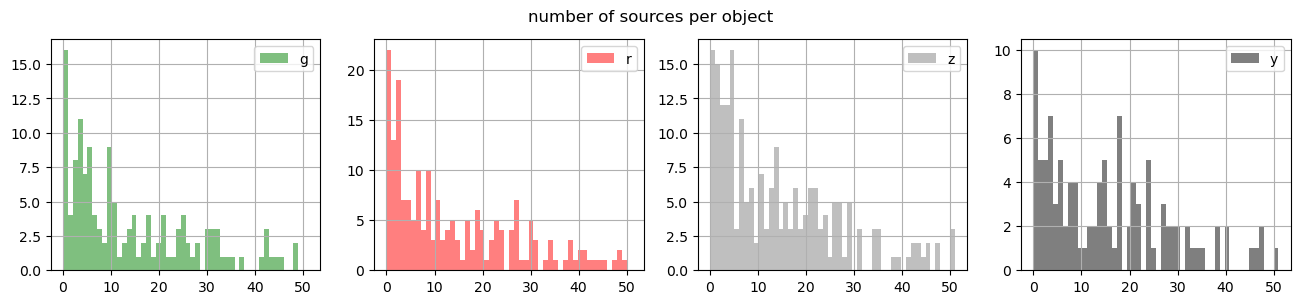

In [58]:
fig,axs = plt.subplots(1,4,figsize=(16,3))
ax=axs[0]
size_source_visit_g.hist(bins=50,range=(0,51.),ax=ax,facecolor="g",alpha=0.5,label="g")
ax.legend()
ax=axs[1]
size_source_visit_r.hist(bins=50,range=(0,51.),ax=ax,facecolor="r",alpha=0.5,label="r")
ax.legend()
ax=axs[2]
size_source_visit_z.hist(bins=50,range=(0,51.),ax=ax,facecolor="grey",alpha=0.5,label="z")
ax.legend()
ax=axs[3]
size_source_visit_y.hist(bins=50,range=(0,51.),ax=ax,facecolor="k",alpha=0.5,label="y")
ax.legend()

plt.suptitle("number of sources per object")

In [59]:
count_source_visit[3,"r"]

1

### Filtering the object using pandas series and dataframe

#### Unstacking a multi-label pandas series into a dataframe

In [60]:
NYMIN = 20. # minimum number of visit in Y band
NBANDMIN = 4 # nimimum number of bands

In [61]:
size_source_visit 

obj_index  band
3          r        1
           z       76
6          g        1
           r       66
           z       65
                   ..
1285       r        2
1305       g        3
           y        1
1318       g       20
1319       g       25
Length: 683, dtype: int64

#### Select the object having at least NYMIN visit in band Y

- however it is useless, the selection will be done on pandas dataframe from unstacked series

In [62]:
cut_NY = size_source_visit[:,'y']  > NYMIN
cut_NY

obj_index
27      False
38       True
43       True
50      False
62       True
        ...  
1219    False
1226    False
1241    False
1282    False
1305    False
Length: 112, dtype: bool

In [63]:
size_source_visit_unstacked = size_source_visit.unstack()
size_source_visit_unstacked 

band,g,r,y,z
obj_index,,,,
3,NaN,1.0,NaN,76.0
6,1.0,66.0,NaN,65.0
10,18.0,64.0,NaN,17.0
18,NaN,4.0,NaN,9.0
22,1.0,54.0,NaN,22.0
...,...,...,...,...
1282,4.0,3.0,2.0,NaN
1285,1.0,2.0,NaN,NaN
1305,3.0,NaN,1.0,NaN


#### Apply the selection on the pandas series

In [64]:
cut_on_size_in_bands = (size_source_visit_unstacked.y>NYMIN) & (size_source_visit_unstacked.g> 10) & (size_source_visit_unstacked.r> 10) & (size_source_visit_unstacked.z> 10) 

size_source_visit_unstacked = size_source_visit_unstacked[cut_on_size_in_bands ] 
size_source_visit_unstacked

band,g,r,y,z
obj_index,,,,
62,73.0,63.0,74.0,41.0
77,42.0,31.0,28.0,20.0
81,60.0,61.0,40.0,64.0
87,42.0,44.0,28.0,45.0
88,31.0,30.0,34.0,20.0
90,26.0,27.0,27.0,27.0
93,41.0,41.0,38.0,42.0
108,59.0,54.0,53.0,54.0
128,32.0,26.0,24.0,24.0


#### Dropping the object not having a visit in all bands on the pandas dataframe from unstacked series

In [65]:
size_source_visit_selected =size_source_visit_unstacked.dropna(axis=0,how='any') 
size_source_visit_selected

band,g,r,y,z
obj_index,,,,
62,73.0,63.0,74.0,41.0
77,42.0,31.0,28.0,20.0
81,60.0,61.0,40.0,64.0
87,42.0,44.0,28.0,45.0
88,31.0,30.0,34.0,20.0
90,26.0,27.0,27.0,27.0
93,41.0,41.0,38.0,42.0
108,59.0,54.0,53.0,54.0
128,32.0,26.0,24.0,24.0


#### Restack the pandas dataframe into a pandas series with multi-label

In [66]:
ser_size_source_visit_selected = size_source_visit_selected.stack()
ser_size_source_visit_selected 

obj_index  band
62         g       73.0
           r       63.0
           y       74.0
           z       41.0
77         g       42.0
                   ... 
1004       z       35.0
1034       g       31.0
           r       26.0
           y       54.0
           z       35.0
Length: 92, dtype: float64

#### Extract the list of selected objects from the pandas dataframe (from unstacked series)

In [67]:
selected_objects_indexes = list(size_source_visit_selected.index)
print(selected_objects_indexes)

[62, 77, 81, 87, 88, 90, 93, 108, 128, 149, 163, 170, 180, 217, 221, 341, 384, 452, 489, 520, 693, 1004, 1034]


In [68]:
#ser_size_source_visit_selected.keys() 

#### Loop on keys multi-label in pandas series

In [69]:
#for name,group in dataJoined_subset.groupby(by=["obj_index","band"]):
#    print("name = ",name)
#    print("group = ",group["visitId"])

In [70]:
#for (idx,band),val in count_source_visit:
#    print(idx,band,val)

### Plot the SED with psf Flux

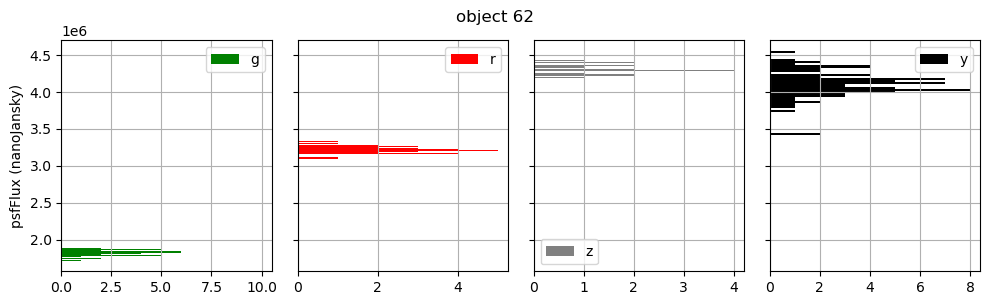

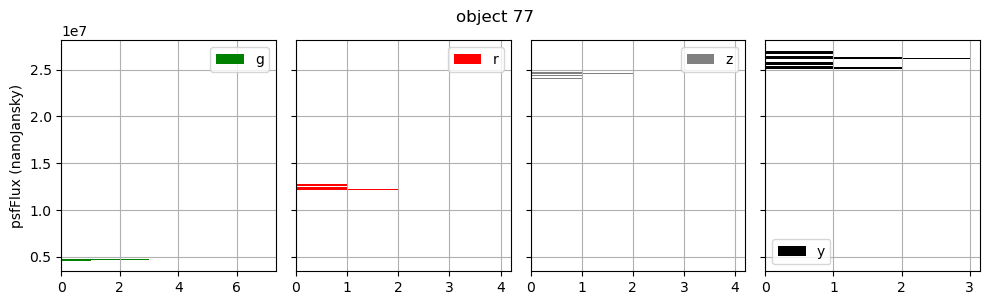

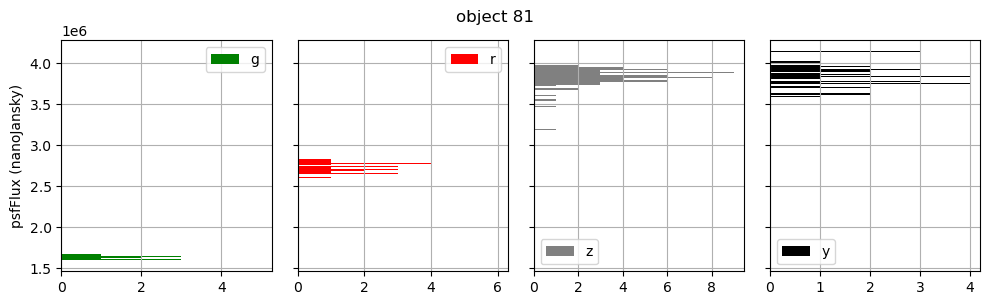

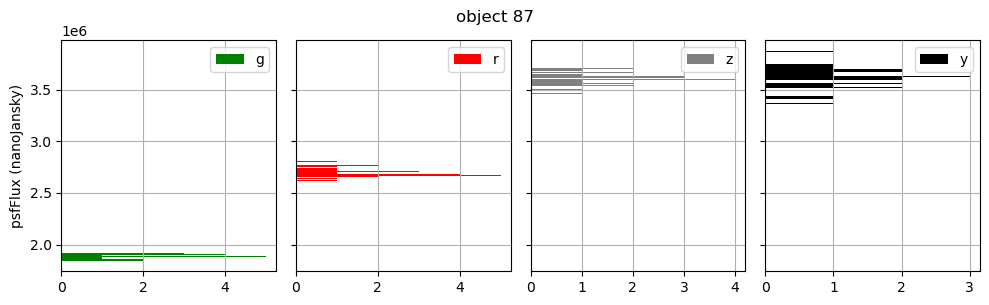

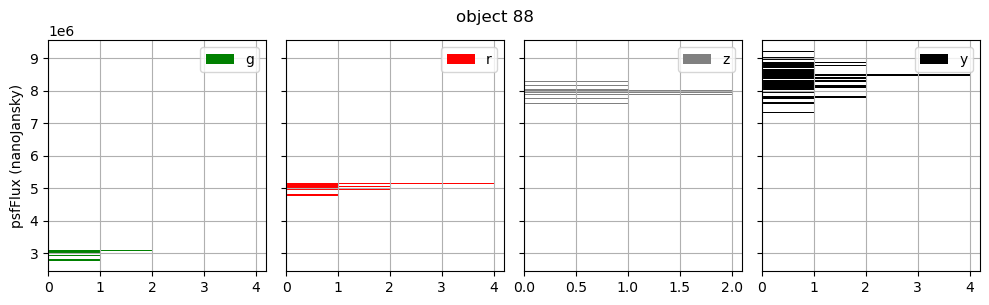

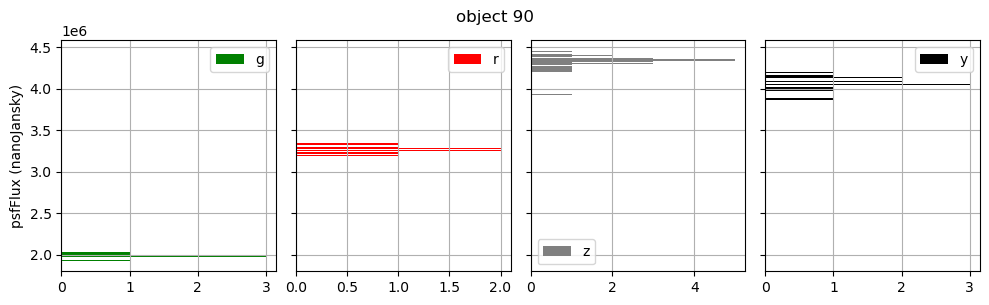

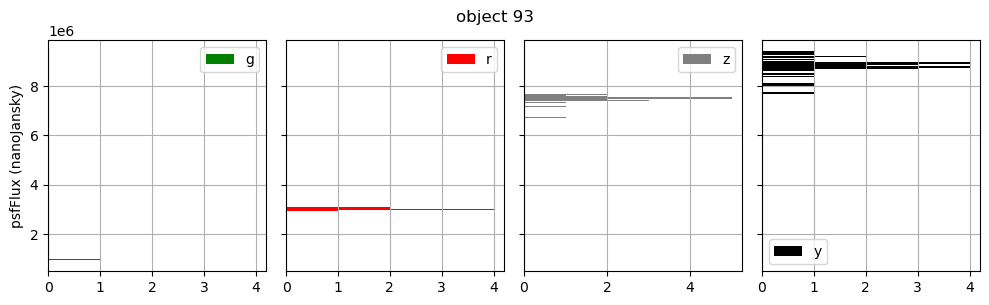

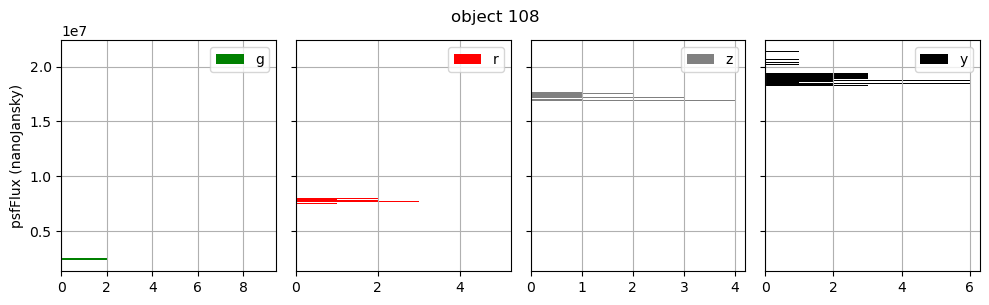

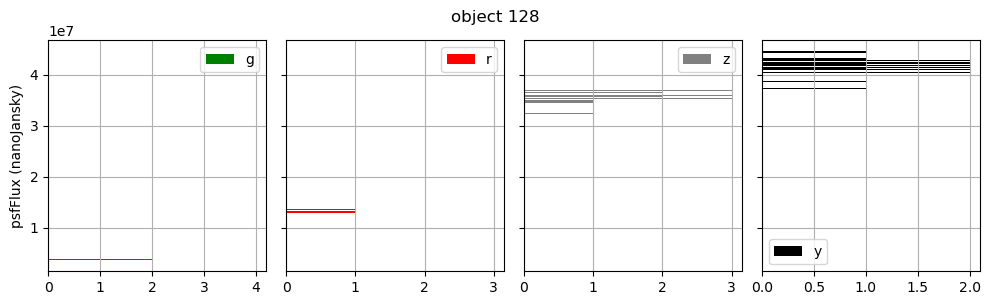

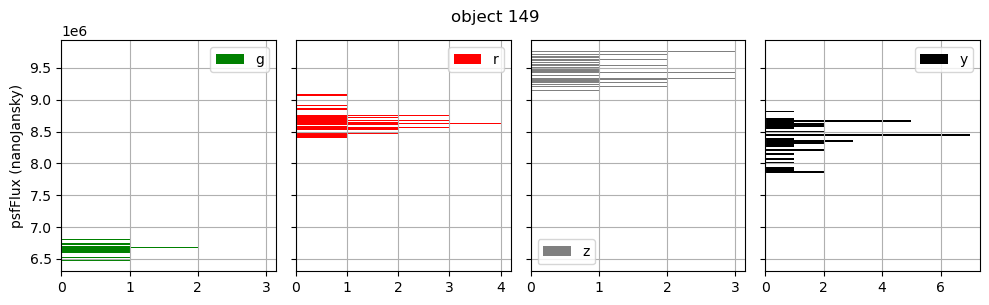

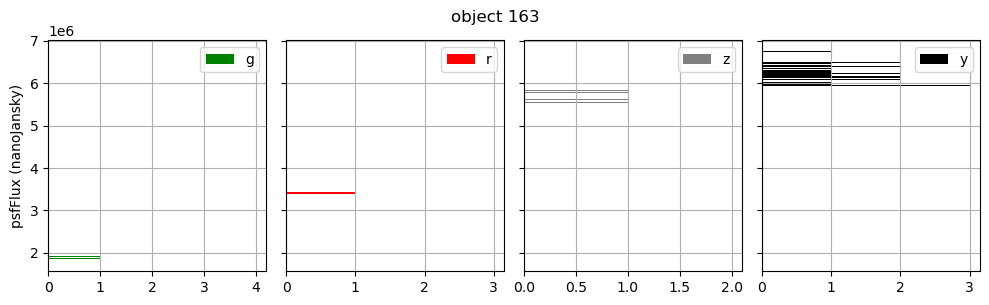

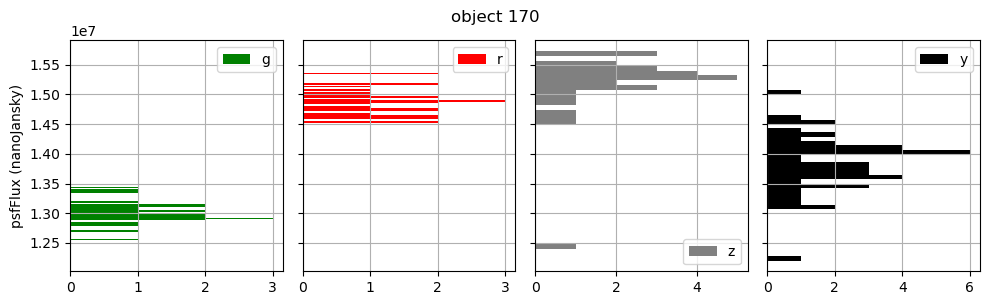

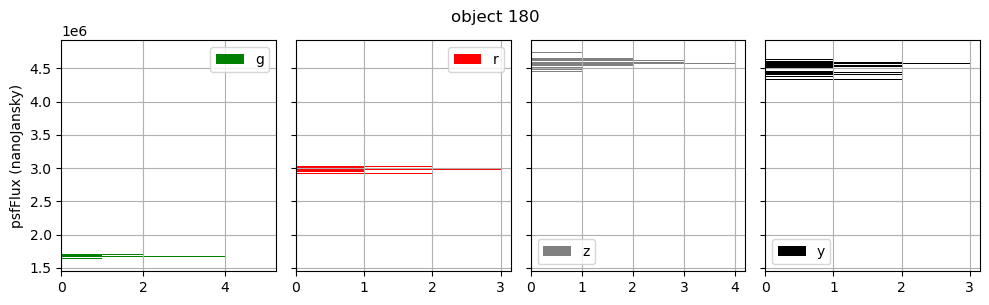

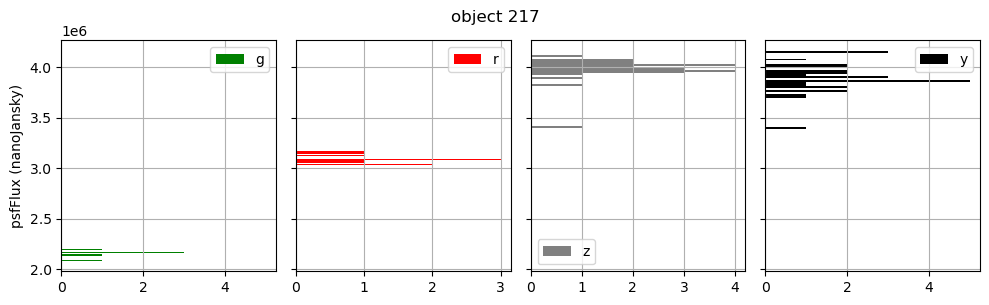

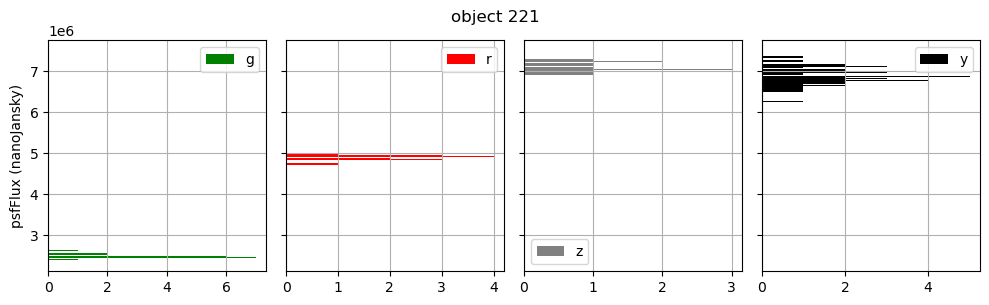

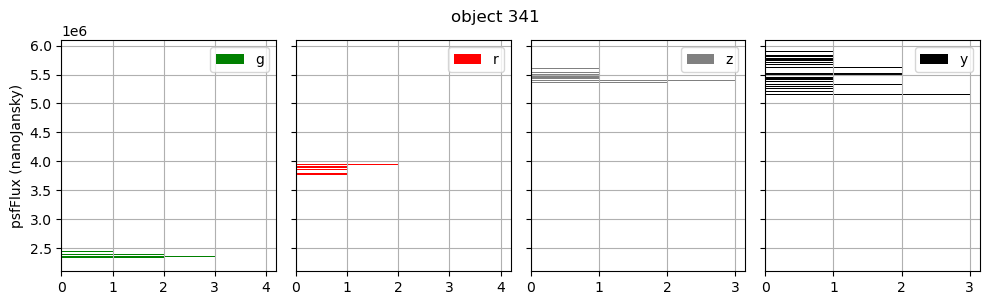

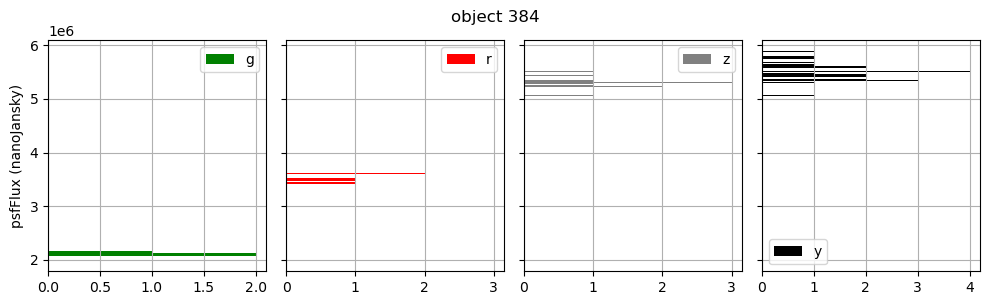

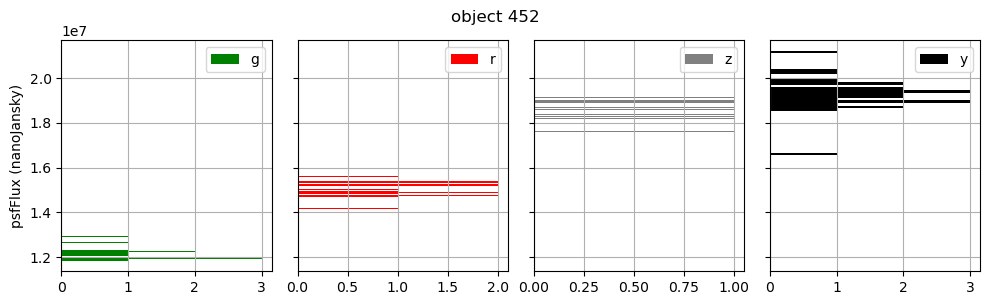

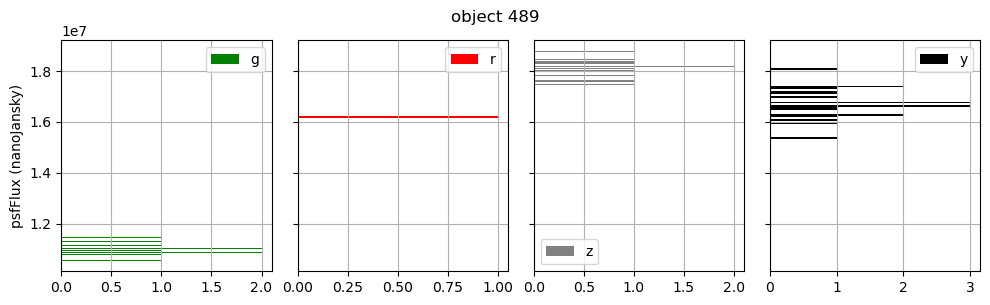

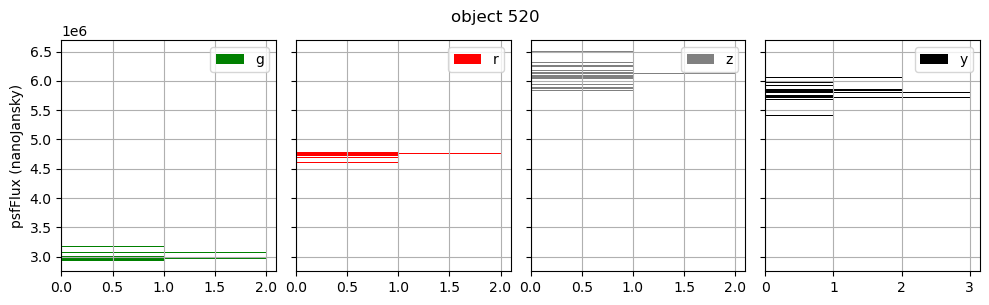

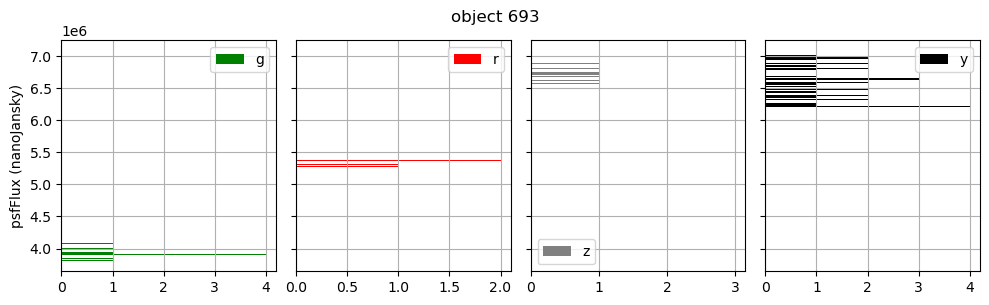

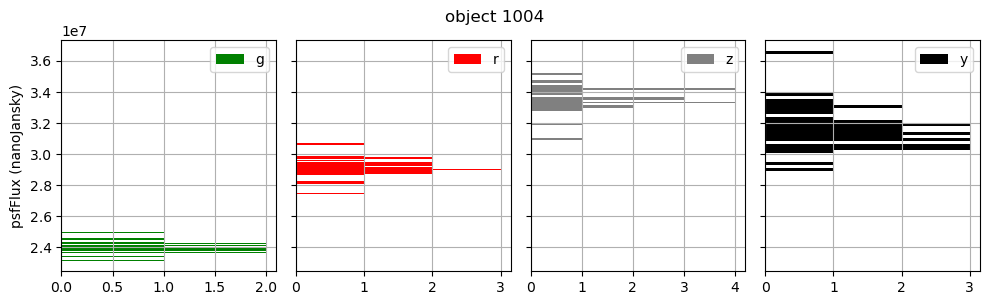

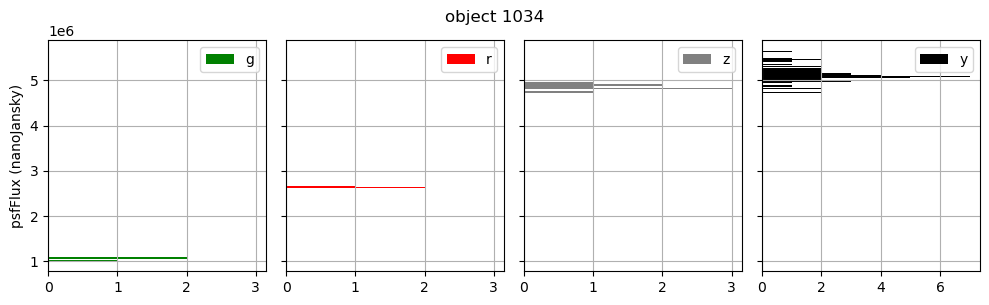

In [71]:
for idx_obj_sel in selected_objects_indexes:
    cut_sel_object = dataJoined_subset.obj_index == idx_obj_sel 
    isolatedStarSources_sel = dataJoined_subset[cut_sel_object] 

    isolatedStarSources_sel_g = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "g"]
    isolatedStarSources_sel_r = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "r"]
    isolatedStarSources_sel_z = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "z"]
    isolatedStarSources_sel_y = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "y"]

    fig,axes = plt.subplots(1,4,figsize=(10,3),sharey=True)
    axs= axes.flatten()
    for idx,ax in enumerate(axs):
        if idx==0:
            isolatedStarSources_sel_g["psfFlux"].hist(bins=40,facecolor="g",ax=ax, orientation="horizontal")
            ax.legend("g")
            ax.set_ylabel("psfFlux (nanoJansky)")
        elif idx==1:
            isolatedStarSources_sel_r["psfFlux"].hist(bins=40,facecolor="r",ax=ax, orientation="horizontal")
            ax.legend("r")
        elif idx==2:
            isolatedStarSources_sel_z["psfFlux"].hist(bins=40,facecolor="grey",ax=ax, orientation="horizontal")
            ax.legend("z")
        elif idx==3:
            isolatedStarSources_sel_y["psfFlux"].hist(bins=40,facecolor="k",ax=ax, orientation="horizontal")
            ax.legend("y")
    plt.tight_layout(h_pad=0)  
    title =f"object {idx_obj_sel}"
    filename = f"sed_color_flux_obj_{idx_obj_sel}.png"
    plt.suptitle(title,y=1.000)
    plt.savefig(filename)
    plt.show()

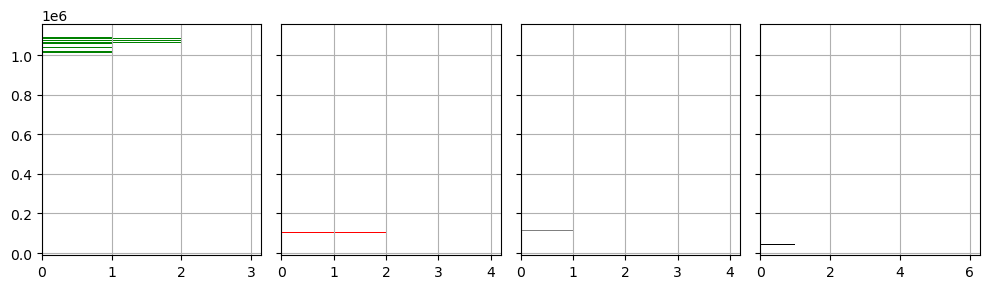

In [72]:
fig,axes = plt.subplots(1,4,figsize=(10,3),sharey=True)
axs= axes.flatten()
for idx,ax in enumerate(axs):
    if idx==0:
        isolatedStarSources_sel_g["psfFlux"].hist(bins=40,facecolor="g",ax=ax, orientation="horizontal")
    elif idx==1:
        isolatedStarSources_sel_r["apFlux_35_0_instFlux"].hist(bins=40,facecolor="r",ax=ax, orientation="horizontal")
    elif idx==2:
        isolatedStarSources_sel_z["apFlux_35_0_instFlux"].hist(bins=40,facecolor="grey",ax=ax, orientation="horizontal")
    elif idx==3:
        isolatedStarSources_sel_y["apFlux_35_0_instFlux"].hist(bins=40,facecolor="k",ax=ax, orientation="horizontal")
plt.tight_layout(h_pad=0)        
#plt.tight_layout()

TypeError: Axes.hist() got multiple values for argument 'x'

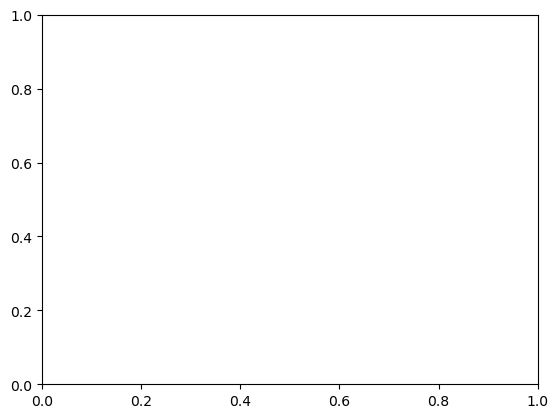

In [73]:
count_source_visit.hist(x="obj_index")

In [ ]:
count_sources = dataJoined.groupby(by="obj_index").count()["psfFlux"]

In [ ]:
count_source.hist(bins=100,range=(0,100))

In [ ]:
assert False

## Plot the per object source 

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])), fontsize=8)
nBins = 16 if len(dataJoined) < 4000 else 100
histData = psfMagStdMmagAll
xLabelStr = "std(psfFlux - psfFluxMean) ({} mmag)".format(band)
medianPsfFluxStd = np.median(histData)
n, bins, patches = ax.hist(histData, bins=nBins, density=True, histtype="step", lw=2, label="data (N = {})".format(len(histData)))
ax.axvline(x=medianPsfFluxStd, color="gray", linestyle='--', linewidth=1, label="median: {:.2f}".format(medianPsfFluxStd))

ax.tick_params(labelsize=7)
ax.set_xlabel(xLabelStr, fontsize=9)
ax.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax.legend(fontsize=8)
if doSaveFigs:
    filename = "{}psfFluxStdHist_{}_{}_{}".format(saveDir, tract, band, collectionStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])), fontsize=8)

medianRaStd = np.median(raStdMasAll)
n, bins, patches = ax.hist(raStdMasAll, bins=nBins, density=True, histtype="step", color="tab:blue", lw=2, label="RA (N = {})".format(len(raStdMasAll)))

medianDecStd = np.median(decStdMasAll)
n, bins, patches = ax.hist(decStdMasAll, bins=nBins, density=True, histtype="step", color="tab:orange", lw=2, label="Dec (N = {})".format(len(decStdMasAll)))

medianRaCosDecStd = np.median(raCosDecStdMasAll)
n, bins, patches = ax.hist(raCosDecStdMasAll, bins=nBins, density=True, histtype="step", color="tab:green", lw=2, label="RA*cos(Dec) (N = {})".format(len(raCosDecStdMasAll)))

ax.axvline(x=medianRaStd, linestyle='--', color="tab:blue", linewidth=1, label="median: {:.2f} (mas)".format(medianRaStd))
ax.axvline(x=medianDecStd, linestyle='--', color="tab:orange", linewidth=1, label="median: {:.2f} (mas)".format(medianDecStd))
ax.axvline(x=medianRaCosDecStd, linestyle='--', color="tab:green", linewidth=1, label="median: {:.2f} (mas)".format(medianRaCosDecStd))


ax.tick_params(labelsize=7)
ax.set_xlabel("std(value - valueMean) ({} mas)".format(band), fontsize=9)
ax.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

# ax.set_xlim(0, 400)
ax.legend(fontsize=8)
if doSaveFigs:
    filename = "{}RaDecStdHist_{}_{}_{}".format(saveDir, tract, band, collectionStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffMmag"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax1.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f} (mmag)\n$\sigma$={:.2f}(mmag)".format(len(dataJoined), mu, sigma))
ax1.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffMmag"], low=3.0, high=3.0).clipped

(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax1.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f} (mmag) \n$\sigma$={:.2f}(mmag)".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax1.fill_between(bins, yFitClipped, alpha=0.2)

ax1.tick_params(labelsize=7)
ax1.set_xlabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax1.set_xlim(-400, 400)
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
n, bins, patches = ax2.hist(dataJoined["psfMagDiffChi"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffChi"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax2.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f}\n$\sigma$={:.2f}".format(len(dataJoined), mu, sigma))
ax2.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffChi"], low=3.0, high=3.0).clipped
(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax2.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f}\n$\sigma$={:.2f}".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax2.fill_between(bins, yFitClipped, alpha=0.2)

ax2.tick_params(labelsize=7)
ax2.set_xlabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax2.set_xlim(-20, 20)
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
dataJoined.columns

In [ ]:
Band_To_Cmap_Dict = {"g":plt.cm.Greens,"r":plt.cm.Reds,"i":plt.cm.Oranges,"z":plt.cm.Purples,"y":plt.cm.Greys}

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["psfMag"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,100), cmap=Band_To_Cmap_Dict[band], label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("psfMag ({})mag ".format(band), fontsize=9)

ax1.set_ylim(-100, 100)
ax1.legend(fontsize=8)
ax1.grid()

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["psfMag"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,100),cmap=Band_To_Cmap_Dict[band], lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("psfMag ({})mag ".format(band), fontsize=9)

ax2.set_ylim(-10, 10)
ax2.legend(fontsize=8)
ax2.grid()
if doSaveFigs:
    filename = "{}psfFluxDiffHist2D_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,50), cmap=Band_To_Cmap_Dict[band], label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("PWV ", fontsize=9)

ax1.set_ylim(-100, 100)
ax1.set_xlim(1, 5.)
ax1.grid()
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,50),cmap=Band_To_Cmap_Dict[band], lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("PWV mm", fontsize=9)

ax2.set_ylim(-10, 10)
ax2.set_xlim(1, 5.)
ax2.grid()
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist2DPWV_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,50), cmap=plt.cm.Reds, label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("PWV ", fontsize=9)

ax1.set_ylim(-100, 100)
ax1.set_xlim(1, 5.)
ax1.grid()
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,50),cmap=plt.cm.Reds, lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("PWV mm", fontsize=9)

ax2.set_ylim(-20, 20)
ax2.set_xlim(1, 5.)
ax2.grid()
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist2DPWV_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
all_nightObs = dataJoined["nightObs"].unique() 
all_X = []
all_Y1 = []
all_EY1 = []
all_Y2 = []
all_EY2 = []
for night in all_nightObs:
    cut = dataJoined["nightObs"] == night
    df_sel = dataJoined[cut]
    pwv = df_sel["PWV"].mean()
    Y1 = df_sel["psfMagDiffMmag"].mean()
    EY1= df_sel["psfMagDiffMmag"].std()
    Y2 = df_sel["psfMagDiffChi"].mean()
    EY2 = df_sel["psfMagDiffChi"].std()
    all_X.append(pwv)
    all_Y1.append(Y1)
    all_EY1.append(EY1)
    all_Y2.append(Y2)
    all_EY2.append(EY2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axhline(y=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,50), cmap=plt.cm.Reds, label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("PWV ", fontsize=9)
ax1.errorbar(all_X,all_Y1,yerr=all_EY1,fmt='o',lw=1,color='b',ecolor='b',markersize=6)

ax1.set_ylim(-50, 50)
ax1.set_xlim(1, 5.)
ax1.grid()
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axhline(y=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,50),cmap=plt.cm.Reds, lw=2, label="data")
ax2.errorbar(all_X,all_Y2,yerr=all_EY2,fmt='o',lw=1,color='b',ecolor='b',markersize=6)

ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("PWV mm", fontsize=9)

ax2.set_ylim(-10, 10)
ax2.set_xlim(1, 5.)
ax2.grid()
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist2DPWV_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)     

In [ ]:
# Split out the smallest and largest PSF mag std objects (just to easily look at the extremes).
largeStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] >= 1.4*medianPsfFluxStd]
smallStdList= [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] < 0.4*medianPsfFluxStd]
for objectIndex in largeStdList:
    print("Large Std: objectIndex = {}  number of matches = {}".format(objectIndex, len(dataJoined[dataJoined["obj_index"] == objectIndex])))
for objectIndex in smallStdList:
    print("Small Std: objectIndex = {}  number of matches = {}".format(objectIndex, len(dataJoined[dataJoined["obj_index"] == objectIndex])))

In [ ]:
# Plot cutouts centered on matched sources from different visits for a couple of objects.
# Selecting from the small/largeStdLists made above to look at the extremes.
imMin, imMax, Q = -0.001, 0.004, 8
expMin, expMax = -25, 100
numSub = 8
for maxBoxSize in [71]:
    plt.close("all")
    for objInd in smallStdList[0:3] + largeStdList[1:2]:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        numObj = len(joinedObjects)
        print("numObj = {} [with obj_index = {}]".format(numObj, objInd))
        nRow = 1 if numObj <= numSub else (numObj // numSub) + 1
        # print("nRow = {}".format(nRow))
        fig, axes = plt.subplots(nRow, numSub, figsize=(3*numSub, 3*nRow), constrained_layout=True)
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        
        psfMag = joinedObjects["psfMag"]
        psfMagErr = joinedObjects["psfMagErr"]
        psfMagDiffMmag = joinedObjects["psfMagDiffMmag"].values
        psfMagStdMmag = psfMagStdMmagDict[objInd]

        clippedMeanRaArray = scipy.stats.sigmaclip(joinedObjects["ra"], low=3.0, high=3.0).clipped
        clippedMeanRa = np.mean(clippedMeanRaArray)
        clippedMeanDecArray = scipy.stats.sigmaclip(joinedObjects["dec"], low=3.0, high=3.0).clipped
        clippedMeanDec = np.mean(clippedMeanDecArray)

        iObj = -1
        for ax in axes.ravel():
            iObj += 1
            if iObj < numObj:
                row = joinedObjects[iObj:iObj + 1]
                detector = row["detector"].values[0]
                visit = row["visit"].values[0]
                psfMag = (row["psfFlux"].values[0]*u.nJy).to(u.ABmag)

                dataId = {"detector": detector, "visit": visit}
                exp = butler.get("calexp", dataId)
                wcs = exp.wcs
                pt = geom.SpherePoint(geom.Angle(row["ra"].values[0], geom.degrees),
                                      geom.Angle(row["dec"].values[0], geom.degrees))
                (xSrc, ySrc) = wcs.skyToPixel(pt)

                boxSize = int(min(maxBoxSize, xSrc, exp.getWidth()-xSrc, ySrc, exp.getHeight()-ySrc) - 1)

                minBbox = geom.Point2I(int(xSrc) - boxSize ,int(ySrc) - boxSize)
                maxBbox = geom.Point2I(int(xSrc) + boxSize, int(ySrc) + boxSize)
                srcBbox = geom.Box2I(minBbox, maxBbox)

                subimg = afwImage.ExposureF(exp, srcBbox, afwImage.PARENT, True)
                subimgRgb = afwRgb.makeRGB(subimg.image.array, None, None, expMin, expMax - expMin, Q)

                im = ax.imshow(subimgRgb, interpolation="nearest", origin="lower")
                ax.text(0.5, 0.06, "psfSig: {:.2f} pix".format(row["psfSigma"].values[0]),
                        color="cyan", fontsize=14, ha="center", va="center", transform=ax.transAxes)
                ax.text(0.5, 0.15, "{:.2f}".format(psfMag),
                        color="violet", fontsize=14, ha="center", va="center", transform=ax.transAxes)

                diffColor = "red" if np.abs(psfMagDiffMmag[iObj]) > 100 else "lawngreen"
                ax.text(0.5, 0.92, "diff: {:.2f} mmag".format(psfMagDiffMmag[iObj]),
                        color=diffColor, fontsize=14, ha="center", va="center", transform=ax.transAxes)

                ax.set_title("{} : {} {}sec".format(iObj,visit, row["expTime"].values[0]), fontsize=12)

        color = "green"
        plt.text(0.5, 0.84, "std: {:.2f} mmag".format(psfMagStdMmag), color=color, fontsize=14,
                 ha="center", va="center", transform=ax.transAxes)

        if doSaveFigs:
            filename = "{}{}_allOjbectsSmallStd_{}_{}_{}".format(saveDir, camera.getName(), objInd, maxBoxSize, collectionStr)
            print("Saving file in: {}".format(filename))
            plt.savefig(filename, dpi=250)

In [ ]:
# Plot all light curves (or as many as you include from stdList)
stdList = [index for index in psfMagStdMmagDict]
# Make light curves for both:
#     psfInstMag: the "instrument" magnitude
#     psfMag: the calibrated magnitude
for magStr in ["psfInstMag", "psfMag"]:
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    for objInd in stdList[:25]:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        xData = joinedObjects["expMidptMjd"]
        yData = joinedObjects[magStr]
        yDataErr = joinedObjects["psfMagErr"]
        yDataSorted = [y for _, y in sorted(zip(xData, yData))]
        yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
        xDataSorted = sorted(xData)
        ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", alpha=0.6, label="{}".format(objInd))
        ax.scatter(xDataSorted, yDataSorted, s=9, alpha=1.0)
    ax.legend(fontsize=6, loc="upper right")
    ax.set_xlabel("{}{}".format("expMidpdMjd", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_{}".format(band, magStr), fontsize=10)
    title = f"Light Curves {magStr} for tract {tract} in band {band} (AUXTEL)"
    ax.set_title(title)
    if doSaveFigs:
        filename = "{}{}_lightCurves_{}".format(saveDir, camera.getName(),collectionStr)
        print("Saving file in: {}".format(filename))
        plt.savefig(filename, dpi=150)
    ax.grid()

In [ ]:
# Plot light curves divided by photo Std
magStr = "psfMag"
largeThresh = min(2.0*medianPsfFluxStd, 0.8*max(psfMagStdMmagDict.values()))
smallThresh = max(0.5*medianPsfFluxStd, 0.2*min(psfMagStdMmagDict.values()))
mediumThreshLower = medianPsfFluxStd - 0.04*medianPsfFluxStd
mediumThreshUpper = medianPsfFluxStd + 0.04*medianPsfFluxStd
largeStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] > largeThresh]
mediumUpperStdList = [index for index in psfMagStdMmagDict if (psfMagStdMmagDict[index] < mediumThreshUpper and psfMagStdMmagDict[index] > medianPsfFluxStd)]
mediumLowerStdList = [index for index in psfMagStdMmagDict if (psfMagStdMmagDict[index] < medianPsfFluxStd and psfMagStdMmagDict[index] > mediumThreshLower)]
smallStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] < smallThresh]
titleStrList = ["psf diff std > {:.2f} mmag".format(largeThresh),
                "psf diff {:.2f} < std < {:.2f} mmag".format(medianPsfFluxStd, mediumThreshUpper),
                "psf diff {:.2f} < std < {:.2f} mmag".format(mediumThreshLower, medianPsfFluxStd),
                "psf diff std < {:.2f} mmag".format(smallThresh)]

fig, axes = plt.subplots(4, 1, figsize=(14, 20))
for stdList, titleStr, ax in zip([largeStdList[:10], mediumUpperStdList[:10], mediumLowerStdList[:10], smallStdList[:10]], titleStrList, axes):
    for objInd in stdList:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        xData = joinedObjects["expMidptMjd"]
        yData = joinedObjects[magStr]
        yDataErr = joinedObjects["psfMagErr"]
        yDataSorted = [y for _, y in sorted(zip(xData, yData))]
        yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
        xDataSorted = sorted(xData)
        ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", alpha=0.6, label="{}".format(objInd))
        ax.scatter(xDataSorted, yDataSorted, s=9, alpha=1.0)
    ax.legend(fontsize=6)
    ax.set_xlabel("{}{}".format("expMidpdMjd", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_psf (mag)".format(band), fontsize=10)
    ax.set_title(titleStr, fontsize=12, pad=4)
    ax.grid()
suptitle = f"Light Curves {magStr} for tract {tract} in band {band} (AUXTEL)"
plt.suptitle(suptitle)
plt.tight_layout()
if doSaveFigs:
    filename = "{}{}_lightCurves_{}".format(saveDir, camera.getName(),collectionStr)
    print("Saving file in: {}".format(filename))
    plt.savefig(filename, dpi=150)

In [ ]:
airmasses = [airmassDict[v] for v in sorted_visitList if v in airmassDict.keys() ]
zeropoints = [zeroPointDict[v] for v in sorted_visitList if v in zeroPointDict.keys()]
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.plot(sorted_visits_mjd,airmasses,marker='o',lw=1,c="blue",label="airmass") 
ax.set_xlabel("MJD")
ax.set_ylabel("airmass")
ax2 =ax.twinx()
ax2.plot(sorted_visits_mjd,zeropoints,marker='o',lw=1,c="red",label="zeropoint")
ax2.set_ylabel("zero-point (mag)")
ax.legend(loc="upper left")
ax.set_ylim(1.,2)
ax.grid()
ax2.legend(loc="upper right")
suptitle = f"Airmass and zero point for tract {tract} in band {band} (AUXTEL)"
ax.set_title(suptitle)
#ax2.set_ylim(27,28.5)

## Difference vs PWV

## Save the sources

In [ ]:
dataJoined.to_csv(fullname_file_output_selectedsources)